In [275]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from string import ascii_lowercase

# from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [9]:
rx_locs = np.load("rx_locs.npy")
rx_times = np.load("rx_times.npy")
n_times_invert = len(rx_times)

In [6]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [10]:
dobs = load_pre_file("dobs.txt")

dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-2]

In [12]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [13]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [15]:
mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(mesh, "target_45.con")

In [16]:
len(full_survey.source_list)

61

In [27]:
src_inds = np.r_[30, 40]
rx_locs[src_inds, 0]

array([  0., 100.])

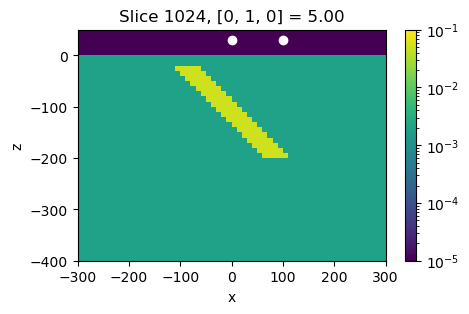

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3)) 

plt.colorbar(mesh.plot_slice(
    model, 
    pcolor_opts={"norm":LogNorm(1e-5, 1e-1)},
    ax=ax,
    normal="Y"
)[0], ax=ax)

ax.plot(rx_locs[src_inds, 0], rx_locs[src_inds, 2], "wo")

ax.set_xlim(300*np.r_[-1, 1])
ax.set_ylim([-400, 50])

ax.set_aspect(1)

In [34]:
src_list_subset = [full_survey.source_list[i] for i in src_inds]
survey_subset = tdem.Survey(src_list_subset)

In [36]:
time_steps = [
    (1e-6, 10),
    (3e-6, 10),
    (1e-5, 10), (3e-5, 10), (1e-4, 20), #(3e-4, 20)
]

In [38]:
simulation = tdem.Simulation3DElectricField(
    mesh=mesh, 
    sigmaMap=maps.IdentityMap(mesh),
    solver=Solver, 
    time_steps=time_steps,
    survey=survey_subset,
    verbose=True
)

In [39]:
fields = simulation.fields(model)

Calculating Initial fields
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
Factoring...   (dt = 3.000000e-06)
Done
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...

In [43]:
mesh_plotting = discretize.TensorMesh(
    [[(10, 100)], [(10, 100)], [(10, 100)]], origin="CCC"
)

In [ ]:


target_x = np.r_[-200, 200]
target_y = np.r_[-400, 400]
target_z_center = -60
target_thickness = 40
target_zlim=np.r_[-200, -20]
target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]

dip = 45
target_x_center=-50
slope = np.tan(-dip*np.pi/180)

x_tmp = np.linspace(target_x.min(), target_x.max())

z_bottom = (x_tmp-target_x_center) * slope + target_z.min()
z_top = (x_tmp-target_x_center) * slope + target_z.max()

z_bottom[z_bottom < target_zlim.min()] = target_zlim.min()
z_bottom[z_bottom > target_zlim.max()] = target_zlim.max()
z_top[z_top > target_zlim.max()] = target_zlim.max()
z_top[z_top < target_zlim.min()] = target_zlim.min()

inds_equal = (z_top == z_bottom)
x_tmp = x_tmp[~inds_equal]
z_bottom = z_bottom[~inds_equal]
z_top = z_top[~inds_equal]

target_outline_x = np.hstack(
    [x_tmp, x_tmp[-1], np.flipud(x_tmp), x_tmp[0]]
)
target_outline_z = np.hstack(
    [z_bottom, z_bottom[-1], np.flipud(z_top), z_bottom[0]]
)


In [47]:
tind = 31
simulation.times[tind]*1e3

np.float64(0.16999999999999998)

In [134]:
src1 = survey_subset.source_list[0]
j1 = fields[src1, "j"]
dbdt1 = fields[src1, "dbdt"]

jy1 = mesh.average_edge_y_to_cell * j1[mesh.n_edges_x:mesh.n_edges_x + mesh.n_edges_y, :]
dbdtx1 = mesh.average_face_x_to_cell * dbdt1[:mesh.n_faces_x, :]
dbdtz1 = mesh.average_face_z_to_cell * dbdt1[-mesh.n_faces_z:, :]

In [135]:
P = discretize.utils.volume_average(mesh, mesh_plotting)

In [136]:
jy1_plot = P * jy1

In [137]:
dbdtx1_plot = P * dbdtx1
dbdtz1_plot = P * dbdtz1

In [138]:
simulation.times[20]*1e3

np.float64(0.03999999999999999)

In [139]:
dbdtplt.shape

(3000000,)

In [140]:
dbdtplt.shape

(3000000,)

In [141]:
mesh_plotting.n_cells*3

3000000

Text(0.5, 0, 'x (m)')

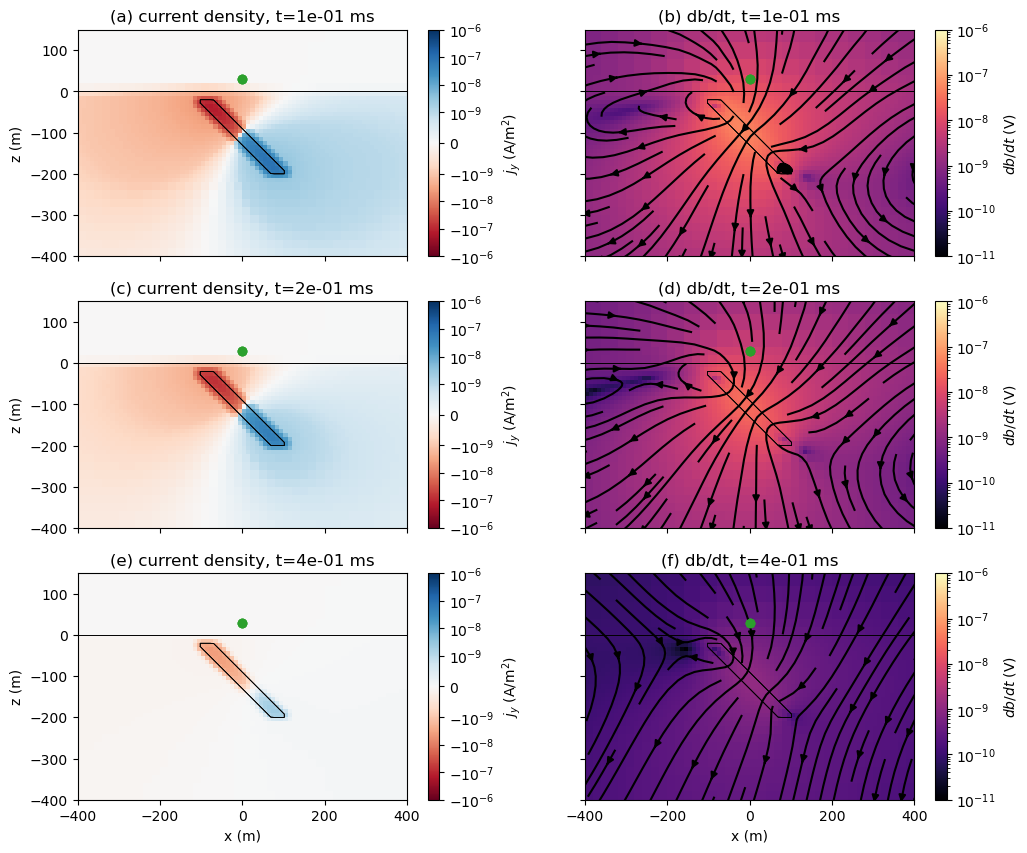

In [312]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True) 


currents_norm = SymLogNorm(linthresh=1e-9, vmin=-1e-6, vmax=1e-6)
dbdt_norm = LogNorm(1e-11, 1e-6)
# tinds = [21, 31, 40]
tinds = [29, 31, 40]

for i, tind in enumerate(tinds): 
    # currents 
    jplt = jy1_plot[:, tind]
    jpltmax = np.max(np.abs(jplt))
    cb = plt.colorbar(
        mesh_plotting.plot_slice(
            jplt, 
            normal="Y",
            pcolor_opts={"cmap":"RdBu", "norm":currents_norm},
            ax=ax[i, 0]
        )[0], ax=ax[i, 0]
    )
    cb.set_label("$j_y$ (A/m$^2$)")
    ax[i, 0].set_title(f"({ascii_lowercase[i*2]}) current density, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 0].set_ylabel("z (m)")
    
    # dbdt
    dbdtplt = np.hstack([dbdtx1_plot[:, tind], np.zeros(mesh_plotting.n_cells), dbdtz1_plot[:, tind]])
    cb = plt.colorbar(
        mesh_plotting.plot_slice(
            dbdtplt, 
            v_type="CCv",
            view="vec",
            normal="Y",
            pcolor_opts={"cmap":"magma", "norm":dbdt_norm},
            ax=ax[i, 1]
        )[0], ax=ax[i, 1]
    )
    cb.set_label("$db/dt$ (V)")
    ax[i, 1].set_title(f"({ascii_lowercase[i*2+1]}) db/dt, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 1].set_ylabel("")
    
    for a in ax.flatten():
        a.set_xlim(400*np.r_[-1, 1])
        a.set_ylim([-400, 150])
        a.set_aspect(1)
        a.set_xlabel("")
        a.plot(src1.location[0], src1.location[2], "C2o", ms=6)
        a.plot(target_outline_x, target_outline_z, "k", lw=0.5)
        a.plot([-500, 500], [0, 0], "k", lw=0.5)

ax[-1, 0].set_xlabel("x (m)")
ax[-1, 1].set_xlabel("x (m)")




In [143]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [144]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/dipping-layer-45"
inv_dicts, models_1d = load_models_and_dicts(directory)

In [145]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [146]:
cs = 10
core_region = 200
npad = 12
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [148]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [239]:
models1d = np.zeros((len(source_list), len(thicknesses1d)+1))

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    models1d[ind, :] = np.flipud(m)

In [240]:
np.where(sounding_inds)

(array([  14,   75,  136,  197,  258,  319,  380,  441,  502,  563,  624,
         685,  746,  807,  868,  929,  990, 1051, 1112, 1173, 1234, 1295,
        1356, 1417, 1478, 1539, 1600, 1661, 1722, 1783, 1844, 1905, 1966]),)

In [241]:
model1 = np.flipud(compiled_1d_models[:, src_inds[0]])

In [242]:
model1.shape

(33,)

In [250]:
sigma_back = 1/500 
sigma_layer = 1/20 

sigma_lower_1d = 1e-4

thicknesses_est = [50, 40]
sigma_est = [sigma_back, sigma_layer, sigma_lower_1d]

In [251]:
thicknesses_true = [90, 40]
sigma_true = [sigma_back, sigma_layer, sigma_back]

(1e-05, 0.1)

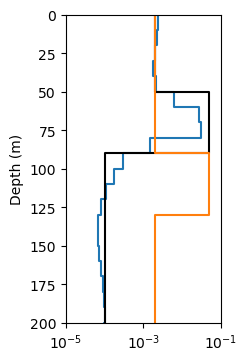

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(model1), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_est, sigma_est, ax=ax, color="k", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="C1", label="recovered"
)
ax.set_ylim([200, 0])
ax.set_xlim([1e-5, 1e-1])


In [179]:
cyl_mesh = discretize.CylindricalMesh(
    [[(10, 40), (10, 20, 1.3)], [np.pi*2], [(10, 20, -1.3), (10, 80), (10, 20, 1.3)]],
    origin="00C"
)

In [265]:
cyl_source_list = simulation.survey.source_list[0]
cyl_sim = tdem.Simulation3DElectricField(
    mesh=cyl_mesh,
    solver=Solver, 
    time_steps=time_steps,
    survey = tdem.Survey(cyl_source_list), 
    sigmaMap=maps.IdentityMap()
)

In [266]:
sigma_layer_true = np.ones(cyl_mesh.n_cells)
sigma_layer_true[cyl_mesh.cell_centers[:, 2] > 0] = 1e-8

sigma_layer_true[cyl_mesh.cell_centers[:, 2] < 0] = sigma_back
sigma_1d = sigma_layer_true.copy()

sigma_layer_true[
    (cyl_mesh.cell_centers[:, 2] < -thicknesses_true[0]) &
    (cyl_mesh.cell_centers[:, 2] > -np.sum(thicknesses_true))
] = sigma_layer

sigma_1d[
    (cyl_mesh.cell_centers[:, 2] < -thicknesses_est[0]) &
    (cyl_mesh.cell_centers[:, 2] > -np.sum(thicknesses_est))
] = sigma_layer
sigma_1d[
    cyl_mesh.cell_centers[:, 2] < -np.sum(thicknesses_est)
] = sigma_lower_1d


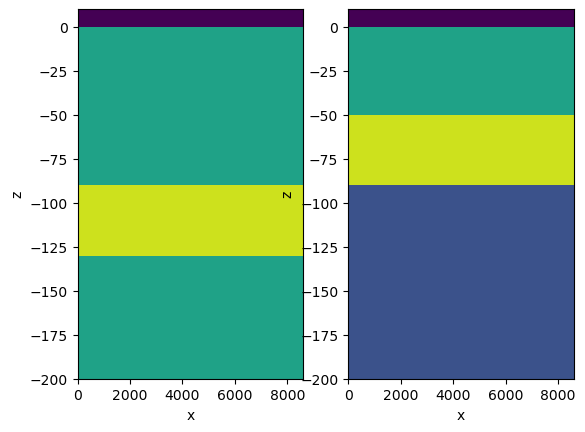

In [267]:
fig, ax = plt.subplots(1, 2)

cyl_mesh.plot_image(
    sigma_layer_true, ax=ax[0],
    pcolor_opts={"norm":LogNorm(1e-5, 1e-1)}
)

cyl_mesh.plot_image(
    sigma_1d, ax=ax[1],
    pcolor_opts={"norm":LogNorm(1e-5, 1e-1)}
)

for a in ax:
    a.set_ylim([-200, 10])

In [268]:
fields_layer_true = cyl_sim.fields(sigma_layer_true)

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


In [269]:
fields_layer_1d = cyl_sim.fields(sigma_1d)

Text(0.5, 0, 'x (m)')

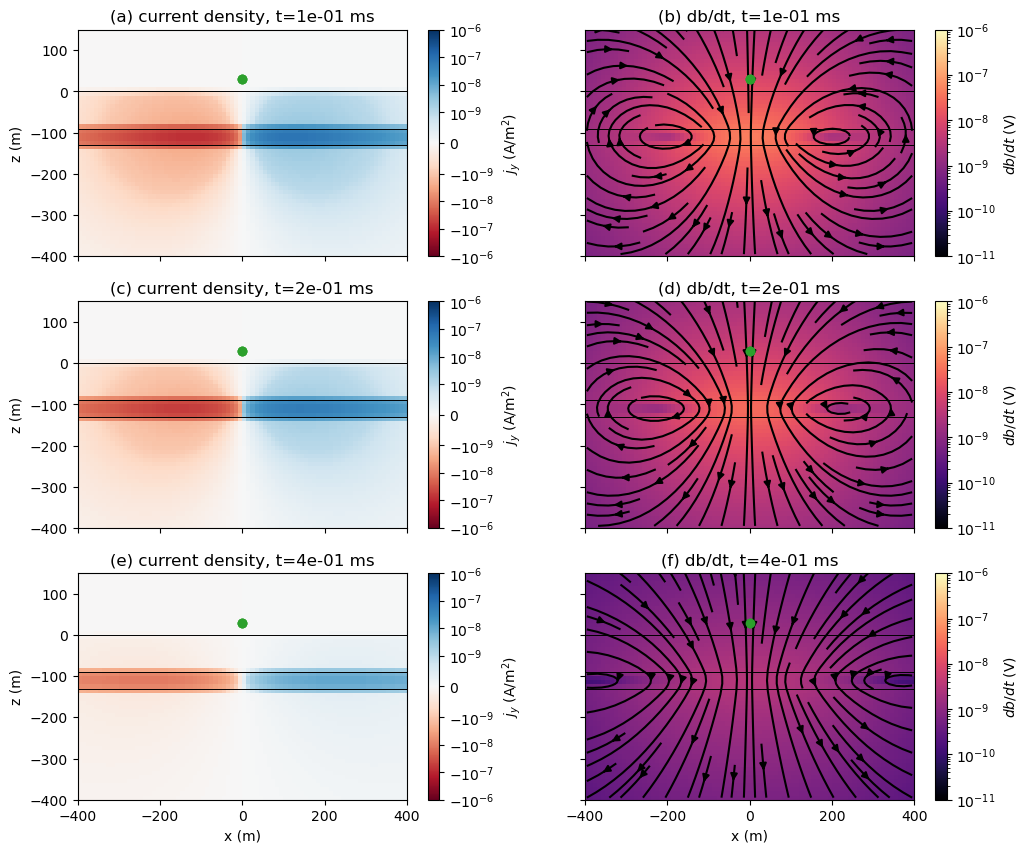

In [313]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True) 

for i, tind in enumerate(tinds): 
    # currents 
    jplt = cyl_mesh.average_edge_y_to_cell * fields_layer_true[:, "j"][:, tind]
    jpltmax = np.max(1.1*np.abs(jplt))
    cb = plt.colorbar(
        cyl_mesh.plot_image(
            jplt, 
            pcolor_opts={"cmap":"RdBu", "norm":currents_norm}, #Normalize(vmin=-jpltmax, vmax=jpltmax)},
            ax=ax[i, 0],
            mirror=True, 
            mirror_data = -jplt, 
        )[0], ax=ax[i, 0]
    )
    cb.set_label("$j_y$ (A/m$^2$)")
    ax[i, 0].set_title(f"({ascii_lowercase[i*2]}) current density, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 0].set_ylabel("z (m)")
    
    # dbdt
    dbdtplt = cyl_mesh.average_face_to_cell_vector * fields_layer_true[:, "dbdt"][:, tind]
    cb = plt.colorbar(
        cyl_mesh.plot_image(
            dbdtplt, 
            v_type="CCv",
            view="vec",
            pcolor_opts={"cmap":"magma", "norm":dbdt_norm},
            ax=ax[i, 1],
            range_x = np.r_[-400, 400],
            range_y = np.r_[-400, 400],
            sample_grid=np.r_[10, 10],
            mirror=True
        )[0], ax=ax[i, 1]
    )
    cb.set_label("$db/dt$ (V)")
    ax[i, 1].set_title(f"({ascii_lowercase[i*2+1]}) db/dt, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 1].set_ylabel("")
    
    for a in ax.flatten():
        a.set_xlim(400*np.r_[-1, 1])
        a.set_ylim([-400, 150])
        a.set_aspect(1)
        a.set_xlabel("")
        a.plot(src1.location[0], src1.location[2], "C2o", ms=6)
        # a.plot(target_outline_x, target_outline_z, "k", lw=0.5)
        a.plot([-500, 500], -thickness_true[0]*np.r_[1, 1], "k", lw=0.5)
        a.plot([-500, 500], -np.sum(thicknesses_true)*np.r_[1, 1], "k", lw=0.5)
        a.plot([-500, 500], [0, 0], "k", lw=0.5)

ax[-1, 0].set_xlabel("x (m)")
ax[-1, 1].set_xlabel("x (m)")




Text(0.5, 0, 'x (m)')

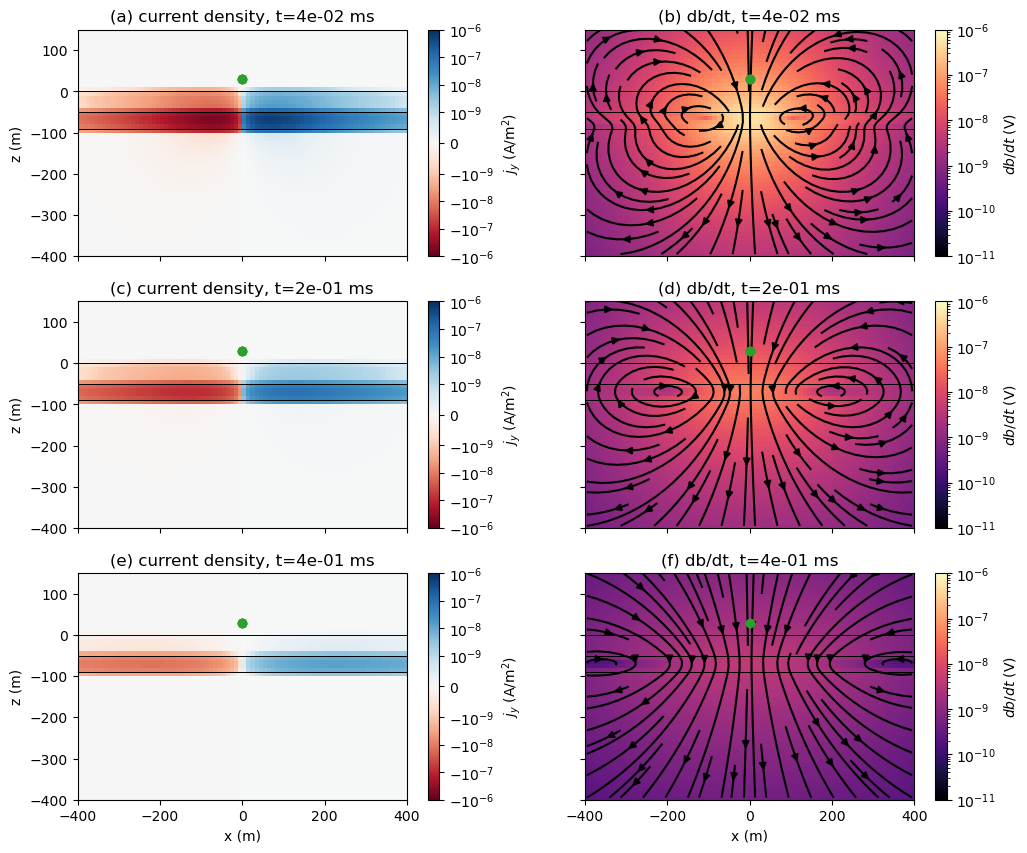

In [314]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True) 

for i, tind in enumerate([20, 31, 40]): 
    # currents 
    jplt = cyl_mesh.average_edge_y_to_cell * fields_layer_1d[:, "j"][:, tind]
    jpltmax = np.max(1.1*np.abs(jplt))
    cb = plt.colorbar(
        cyl_mesh.plot_image(
            jplt, 
            pcolor_opts={"cmap":"RdBu", "norm":currents_norm}, #Normalize(vmin=-jpltmax, vmax=jpltmax)},
            ax=ax[i, 0],
            mirror=True, 
            mirror_data = -jplt, 
        )[0], ax=ax[i, 0]
    )
    cb.set_label("$j_y$ (A/m$^2$)")
    ax[i, 0].set_title(f"({ascii_lowercase[i*2]}) current density, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 0].set_ylabel("z (m)")
    
    # dbdt
    dbdtplt = cyl_mesh.average_face_to_cell_vector * fields_layer_1d[:, "dbdt"][:, tind]
    cb = plt.colorbar(
        cyl_mesh.plot_image(
            dbdtplt, 
            v_type="CCv",
            view="vec",
            pcolor_opts={"cmap":"magma", "norm":dbdt_norm},
            ax=ax[i, 1],
            range_x = np.r_[-400, 400],
            range_y = np.r_[-400, 400],
            sample_grid=np.r_[10, 10],
            mirror=True
        )[0], ax=ax[i, 1]
    )
    cb.set_label("$db/dt$ (V)")
    ax[i, 1].set_title(f"({ascii_lowercase[i*2+1]}) db/dt, t={simulation.times[tind]*1e3:1.0e} ms")
    ax[i, 1].set_ylabel("")
    
    for a in ax.flatten():
        a.set_xlim(400*np.r_[-1, 1])
        a.set_ylim([-400, 150])
        a.set_aspect(1)
        a.set_xlabel("")
        a.plot(src1.location[0], src1.location[2], "C2o", ms=6)
        # a.plot(target_outline_x, target_outline_z, "k", lw=0.5)
        a.plot([-500, 500], -thicknesses_est[0]*np.r_[1, 1], "k", lw=0.5)
        a.plot([-500, 500], -np.sum(thicknesses_est)*np.r_[1, 1], "k", lw=0.5)
        a.plot([-500, 500], [0, 0], "k", lw=0.5)

ax[-1, 0].set_xlabel("x (m)")
ax[-1, 1].set_xlabel("x (m)")


